Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - loss: 0.8204 - sparse_categorical_accuracy: 0.6892 - val_loss: 0.3093 - val_sparse_categorical_accuracy: 0.8910
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - loss: 0.2763 - sparse_categorical_accuracy: 0.9091 - val_loss: 0.2867 - val_sparse_categorical_accuracy: 0.8978
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - loss: 0.2108 - sparse_categorical_accuracy: 0.9271 - val_loss: 0.2617 - val_sparse_categorical_accuracy: 0.9128
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - loss: 0.1245 - sparse_categorical_accuracy: 0.9621 - val_loss: 0.2442 - val_sparse_categorical_accuracy: 0.9210
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - loss: 0.1051 - sparse_categorical_accuracy: 0.9666 - val_loss: 0.2616 - val_sparse_categorical_accuracy: 0.9155


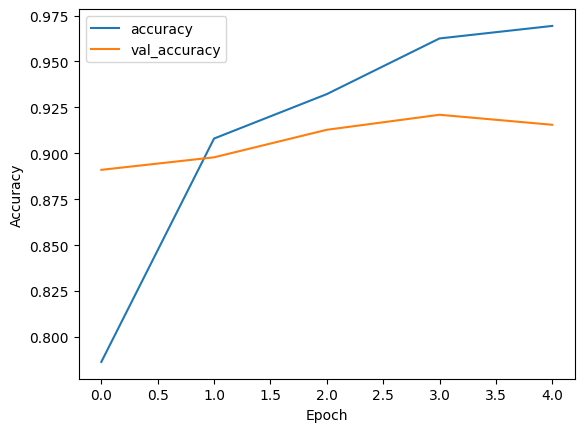

23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - loss: 0.2593 - sparse_categorical_accuracy: 0.9232
Test Accuracy: 0.9155313372612


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load dataset
(ds_train, ds_test), ds_info = tfds.load(
    'tf_flowers', split=['train[:80%]', 'train[80%:]'], as_supervised=True, with_info=True
)

# Preprocess function
def format_image(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0
    return image, label

ds_train = ds_train.map(format_image).batch(32).shuffle(1000)
ds_test = ds_test.map(format_image).batch(32)

# Load pre-trained MobileNetV2 from TensorFlow Hub
base_model = hub.KerasLayer(
    "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
    trainable=False
)

# Functional API Approach
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Lambda(lambda img: base_model(img))(inputs)

x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Prevent overfitting
outputs = tf.keras.layers.Dense(ds_info.features['label'].num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

# Train the model
history = model.fit(ds_train, epochs=5, validation_data=ds_test)

# Plot results
plt.plot(history.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate on test set
test_loss, test_acc = model.evaluate(ds_test)
print("Test Accuracy:", test_acc)


Epoch 1/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 90s 109ms/step - accuracy: 0.7652 - loss: 0.5131 - val_accuracy: 0.8550 - val_loss: 0.3371
Epoch 2/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 105ms/step - accuracy: 0.8566 - loss: 0.3415 - val_accuracy: 0.8572 - val_loss: 0.3281
Epoch 3/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 105ms/step - accuracy: 0.8569 - loss: 0.3296 - val_accuracy: 0.8585 - val_loss: 0.3239


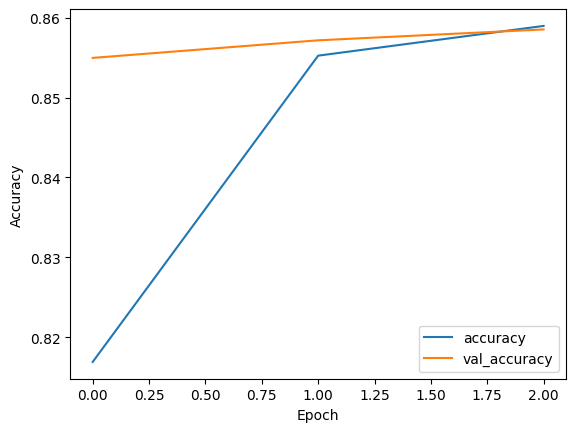

782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step - accuracy: 0.8570 - loss: 0.3270
Test Accuracy: 0.858519971370697


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load IMDb dataset
(ds_train, ds_test), ds_info = tfds.load(
    'imdb_reviews', split=['train', 'test'], as_supervised=True, with_info=True
)

# Load pre-trained Universal Sentence Encoder (USE) from TensorFlow Hub
embed = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=False)

# Preprocess function
def preprocess_text(text, label):
    return text, label  # Ensure text has correct shape

ds_train = ds_train.map(preprocess_text).batch(32).shuffle(1000)
ds_test = ds_test.map(preprocess_text).batch(32)

# Build Model using Functional API
inputs = tf.keras.Input(shape=(), dtype=tf.string)
x = tf.keras.layers.Lambda(lambda txt: embed(txt), output_shape=(512,))(inputs)  # Wrap in Lambda layer
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

# Train the model
history = model.fit(ds_train, epochs=3, validation_data=ds_test)

# Plot results
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate on test set
test_loss, test_acc = model.evaluate(ds_test)
print("Test Accuracy:", test_acc)
